In [ ]:
import cv2, numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# -------- helpers --------
def binarize_fg_white(gray):
    if gray.dtype != np.uint8: gray = gray.astype(np.uint8)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # ensure foreground is white
    if np.mean(bw) > 127: bw = 255 - bw
    return bw

def estimate_stroke_width(bw_fg_white):
    # distance transform on foreground (white)
    dist = cv2.distanceTransform((bw_fg_white>0).astype(np.uint8), cv2.DIST_L2, 3)
    # robust median; multiply by 2 to convert radius->diameter
    sw = max(1.0, 2.0 * np.median(dist[dist>0]))
    return sw

def resample_contour(cnt, step=1.0):
    """Uniformly resample a contour to approx equal arc step (in px)."""
    pts = cnt.reshape(-1,2).astype(np.float32)
    d = np.sqrt(((pts[1:]-pts[:-1])**2).sum(1))
    s = np.concatenate([[0], np.cumsum(d)])
    L = s[-1]
    if L < step or len(pts) < 3: return pts
    t = np.arange(0, L, step, dtype=np.float32)
    # linear interp
    x = np.interp(t, s, pts[:,0])
    y = np.interp(t, s, pts[:,1])
    return np.stack([x,y], 1)

def smooth_poly(P, win):
    if win <= 1: return P
    k = int(max(1, win//2*2+1))  # odd
    # box filter via cv2.blur
    pad = k//2
    Ppad = np.vstack([P[[0]].repeat(pad,0), P, P[[-1]].repeat(pad,0)]).astype(np.float32)
    xs = cv2.blur(Ppad[:,0:1], (k,1))[pad:-pad,0]
    ys = cv2.blur(Ppad[:,1:2], (k,1))[pad:-pad,0]
    return np.stack([xs,ys],1)

def rdp(P, eps):
    if len(P) < 3: return P
    a, b = P[0], P[-1]
    ab = b - a
    ab2 = (ab**2).sum()
    if ab2 == 0:
        d2 = ((P - a)**2).sum(1)
    else:
        t = np.clip(((P - a) @ ab) / ab2, 0, 1)
        proj = a + np.outer(t, ab)
        d2 = ((P - proj)**2).sum(1)
    i = int(np.argmax(d2))
    if d2[i] > eps*eps:
        left = rdp(P[:i+1], eps)
        right = rdp(P[i:], eps)
        return np.vstack([left[:-1], right])
    else:
        return np.vstack([a, b])

def turn_angles(P):
    if len(P) < 3: return np.array([]), []
    v1 = P[1:-1]-P[:-2]; v2 = P[2:]-P[1:-1]
    n1 = np.linalg.norm(v1,1)+1e-6; n2 = np.linalg.norm(v2,1)+1e-6  # L1 norm works fine here
    cos = np.clip(np.sum(v1*v2,1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v2,axis=1)+1e-6), -1, 1)
    ang = np.degrees(np.arccos(cos))
    idx = np.arange(1, len(P)-1)
    return ang, idx

# -------- main detection --------
def detect_corners_thickness_invariant(gray,
                                       resample_step_factor=0.6,
                                       smooth_win_factor=1.0,
                                       rdp_eps_factor=0.6,
                                       angle_thresh_deg=70,
                                       min_run_factor=1.0,
                                       merge_eps_factor=0.8):
    """
    All factors are multiples of estimated stroke width (sw).
    Returns Nx2 integer (x,y) corner coordinates.
    """
    bw = binarize_fg_white(gray)
    sw = estimate_stroke_width(bw)

    # params in pixels
    step = max(1.0, resample_step_factor * sw)
    win  = max(1, int(round(smooth_win_factor * sw)))
    eps  = max(1.0, rdp_eps_factor * sw)
    min_run = max(1.0, min_run_factor * sw)
    merge_eps = max(1.0, merge_eps_factor * sw)

    contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cand = []

    for cnt in contours:
        if len(cnt) < 5: continue
        P = resample_contour(cnt, step=step)
        if len(P) < 5: continue
        Ps = smooth_poly(P, win=win)
        Q = rdp(Ps, eps=eps)
        if len(Q) < 3: continue

        # corner candidates: interior vertices with angle >= threshold and runs long enough
        ang, idx = turn_angles(Q)
        for a, i in zip(ang, idx):
            # enforce run length on each side (distance along Q)
            left_len  = np.linalg.norm(Q[i]-Q[i-1])
            right_len = np.linalg.norm(Q[i+1]-Q[i])
            if a >= angle_thresh_deg and left_len >= (min_run/len(Q)) and right_len >= (min_run/len(Q)):
                cand.append(Q[i])

    if not cand:
        return np.zeros((0,2), np.int32)

    pts = np.array(cand, dtype=np.float32)

    # merge duplicates across all contours (pairs from opposite stroke edges collapse to one)
    labels = DBSCAN(eps=merge_eps, min_samples=1).fit(pts).labels_
    out = []
    for lab in np.unique(labels):
        m = pts[labels==lab].mean(axis=0)
        out.append(np.round(m).astype(np.int32))
    return np.vstack(out)

# -------- visualize (1-px colored dots) --------
def overlay_1px_dots(gray, pts):
    vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    palette = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)]
    for i,(x,y) in enumerate(pts):
        vis[y, x] = palette[i % len(palette)]
    return vis


In [ ]:
import cv2, numpy as np
from sklearn.cluster import DBSCAN

def binarize_fg_white(gray):
    if gray.dtype != np.uint8: gray = gray.astype(np.uint8)
    # Otsu; ensure foreground is white (1)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if np.mean(bw) > 127: bw = 255 - bw
    return bw

def estimate_stroke_width(bw_fg_white):
    dist = cv2.distanceTransform((bw_fg_white>0).astype(np.uint8), cv2.DIST_L2, 3)
    sw = max(1.0, 2.0 * np.median(dist[dist>0]))  # diameter-ish
    return sw, dist

def resample_contour(cnt, step):
    P = cnt.reshape(-1,2).astype(np.float32)
    if len(P) < 3: return P
    d = np.sqrt(((P[1:]-P[:-1])**2).sum(1))
    s = np.concatenate([[0], np.cumsum(d)])
    if s[-1] < step: return P
    t = np.arange(0, s[-1], step, dtype=np.float32)
    x = np.interp(t, s, P[:,0]); y = np.interp(t, s, P[:,1])
    return np.stack([x,y],1)

def smooth_poly(P, win):
    if win <= 1: return P
    k = int(max(1, round(win)))
    if k % 2 == 0: k += 1
    pad = k//2
    Ppad = np.vstack([P[[0]].repeat(pad,0), P, P[[-1]].repeat(pad,0)]).astype(np.float32)
    xs = cv2.blur(Ppad[:,0:1], (k,1))[pad:-pad,0]
    ys = cv2.blur(Ppad[:,1:2], (k,1))[pad:-pad,0]
    return np.stack([xs,ys],1)

def rdp(P, eps):
    if len(P) < 3: return P
    a, b = P[0], P[-1]
    ab = b - a
    ab2 = (ab**2).sum()
    if ab2 == 0:
        d2 = ((P - a)**2).sum(1)
    else:
        t = np.clip(((P - a) @ ab) / ab2, 0, 1)
        proj = a + np.outer(t, ab)
        d2 = ((P - proj)**2).sum(1)
    i = int(np.argmax(d2))
    if d2[i] > eps*eps:
        return np.vstack([rdp(P[:i+1], eps)[:-1], rdp(P[i:], eps)])
    return np.vstack([a, b])

def turn_angles(P):
    if len(P) < 3: return np.array([]), []
    v1 = P[1:-1]-P[:-2]; v2 = P[2:]-P[1:-1]
    n1 = np.linalg.norm(v1, axis=1)+1e-6
    n2 = np.linalg.norm(v2, axis=1)+1e-6
    cos = np.clip(np.sum(v1*v2,1)/(n1*n2), -1, 1)
    ang = np.degrees(np.arccos(cos))
    idx = np.arange(1, len(P)-1)
    return ang, idx

def detect_corners_thickness_gated(
    gray,
    resample_step_factor=0.6,
    smooth_win_factor=1.0,
    rdp_eps_factor=0.6,
    angle_thresh_deg=70,
    min_edge_step_factor=1.0,
    dt_window_factor=1.0,      # DT patch half-size ~ 1.0*sw
    dt_peak_factor=0.7,        # require max(DT) >= 0.7*sw
    merge_eps_factor=0.8       # DBSCAN merge radius ~ 0.8*sw
):
    """
    Thickness-invariant corner detector with Distance Transform gating.
    Returns Nx2 int (x,y).
    """
    bw = binarize_fg_white(gray)
    sw, dist = estimate_stroke_width(bw)

    # scale -> pixels
    step = max(1.0, resample_step_factor * sw)
    win  = max(1.0, smooth_win_factor   * sw)
    eps  = max(1.0, rdp_eps_factor      * sw)
    min_edge = max(1.0, min_edge_step_factor * sw)
    wdt = int(max(1, round(dt_window_factor * sw)))
    dt_peak = dt_peak_factor * sw
    merge_eps = max(1.0, merge_eps_factor * sw)

    contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cand = []

    for cnt in contours:
        if len(cnt) < 5: continue
        P = resample_contour(cnt, step=step)
        if len(P) < 5: continue
        Ps = smooth_poly(P, win=win)
        Q = rdp(Ps, eps=eps)
        if len(Q) < 3: continue

        ang, idx = turn_angles(Q)
        for a, i in zip(ang, idx):
            # require noticeable change and minimal arc on both sides
            if a < angle_thresh_deg:
                continue
            if np.linalg.norm(Q[i]-Q[i-1]) < min_edge:
                continue
            if np.linalg.norm(Q[i+1]-Q[i]) < min_edge:
                continue

            # DT gating: keep only if local thickness is high
            x, y = int(round(Q[i,0])), int(round(Q[i,1]))
            y0, y1 = max(0, y-wdt), min(dist.shape[0], y+wdt+1)
            x0, x1 = max(0, x-wdt), min(dist.shape[1], x+wdt+1)
            if dist[y0:y1, x0:x1].max() >= dt_peak:
                cand.append(Q[i])

    if not cand:
        return np.zeros((0,2), np.int32)

    pts = np.array(cand, dtype=np.float32)

    # Merge duplicates (two sides of thick stroke -> one corner)
    labels = DBSCAN(eps=merge_eps, min_samples=1).fit(pts).labels_
    out = []
    for lab in np.unique(labels):
        m = pts[labels==lab].mean(axis=0)
        out.append(np.round(m).astype(np.int32))
    return np.vstack(out)


corners: 15


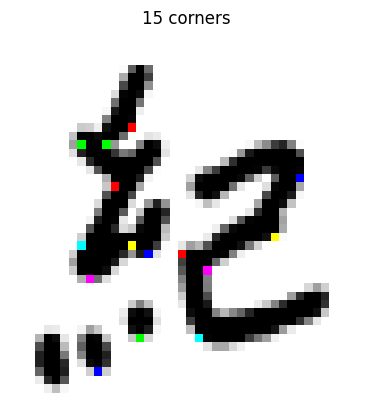

In [ ]:
def overlay_1px_dots(gray, pts):
    vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    palette = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)]
    for i,(x,y) in enumerate(pts):
        vis[y, x] = palette[i % len(palette)]
    return vis

img = cv2.imread("/content/drive/MyDrive/samples_segmented_chars/p1_upload/RC04844/page_1/c37.png", cv2.IMREAD_GRAYSCALE)
corners = detect_corners_thickness_gated(
    img,
    angle_thresh_deg=33,     # ↑ stricter corners
    dt_peak_factor=0.6,      # ↑ demand thicker neighborhood
    min_edge_step_factor=1.4 # ↑ demand longer straight runs
)
print("corners:", len(corners))
vis = overlay_1px_dots(img, corners)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"{len(corners)} corners"); plt.show()
